In [2]:
import networkx as nx
import numpy as np
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import pickle

from panchamy.cut_graph_to_boundaries import cut_graph

In [3]:
import os
os.getcwd()

'C:\\Users\\isvandroffelaa\\Documents\\model\\coarsening\\pruning'

In [4]:
for i in range(5):
    print(i)

0
1
2
3
4


In [5]:
city='Rotterdam'

In [17]:
filepath=f"../data/networks/{city}.graph.graphml"
# ox.save_graph_geopackage(G, filepath=filepath)
G = ox.load_graphml(filepath=filepath)

with open(f'../data/networks/escape_nodes_{city}.pkl', 'rb') as f:
    escape_nodes_ = pickle.load(f)
    
with open(f'../data/networks/fugitive_start_{city}.pkl', 'rb') as f:
    fugitive_start = pickle.load(f)
    
with open(f'../data/networks/start_police_{city}.pkl', 'rb') as f:
    police_start = pickle.load(f)

escape_nodes = []
for node in escape_nodes_:
    if node in G.nodes():
        if nx.has_path(G, source=fugitive_start, target=node):
            escape_nodes.append(node)
            
G.graph['crs'] = 4326
G_orig = G.copy()

In [28]:
exempt_ids = police_start + escape_nodes + [fugitive_start]
exempt_ids

[44498104,
 602273209,
 1560737686,
 44176714,
 4002905728,
 44118802,
 44132836,
 44136945,
 44140776,
 44142413,
 44143921,
 44145003,
 44152744,
 44154184,
 44156362,
 44156963,
 44157300,
 44158213,
 44162358,
 44162847,
 44164163,
 44170518,
 44171879,
 44174799,
 44177139,
 44177581,
 44177897,
 44184056,
 44195071,
 44206856,
 44221221,
 44224179,
 44254956,
 44260928,
 44299057,
 44341727,
 44349037,
 44355197,
 44357568,
 44363257,
 44371416,
 44372815,
 44392228,
 44397464,
 44406962,
 44409789,
 44409874,
 44411753,
 44421034,
 44426497,
 44429449,
 44436264,
 44440194,
 44440724,
 44443914,
 44444526,
 44444721,
 44449398,
 44463270,
 44463844,
 44467732,
 44468388,
 44470228,
 44476443,
 44484007,
 44485447,
 44500536,
 44543693,
 44563930,
 275900857,
 275902274,
 275904807,
 288169675,
 289070523,
 322017885,
 322070776,
 322906333,
 322906357,
 322906465,
 323145423,
 330658056,
 330679502,
 331166803,
 602474365,
 621490909,
 722870763,
 846232067,
 846348635,
 9445179

In [19]:
def node_colors(G, escape_nodes, fugitive_start, police_start):
    node_size = []
    node_color = []
    for u, data in G.nodes(data=True):
        if u == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif u in police_start:
            node_size.append(40)
            node_color.append('tab:blue')
        elif u in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')
        
        else:
            node_size.append(0)
            node_color.append('lightgray')
    
    return node_size, node_color


In [20]:
def edge_colors(G):
    edge_color = ['lightgray'] * len(G.edges())
    edge_size = [1] * len(G.edges())
    # for index, edge in enumerate(G.edges()):
    #     if edge in edges_fugitive:
    #         edge_color[index] = 'tab:orange'
    #         edge_size[index] = 2

    return edge_size, edge_color

In [21]:
len(G.nodes())

7108

In [22]:
pruning = True
i = 0
while pruning:
    spn = ox.stats.count_streets_per_node(G)
    # spn = ox.stats.streets_per_node(G)
    dead_end_nodes = [node for node, count in spn.items() if (count <= 1 and node not in exempt_ids)]

    print(i, (len(G.nodes()) - len(dead_end_nodes)))

    if dead_end_nodes:
        G.remove_nodes_from(dead_end_nodes)
        ox.save_graphml(G, f"results/pruned_network_{city}_iter{i}.graph.graphml")
    else:
        pruning=False

    i += 1

0 6321
1 6231
2 6197
3 6189
4 6185
5 6182
6 6181
7 6181


In [23]:
# tolerance = 0.00001
# 
# G_pruned = ox.simplification.consolidate_intersections(G, tolerance=tolerance, rebuild_graph=True, dead_ends=False)
# len(G_pruned.nodes())

In [24]:
# if city == 'Amsterdam':
#     from shapely import LineString
#     for u, v, data in G_pruned.edges(data=True):
#         if type((data['geometry'])) != LineString:
#             try:
#                 data['geometry'] = data['geometry'][data['u_original'], data['v_original'], 0]
#                 nx.set_edge_attributes(G_pruned, {(u, v, 0): data})
#             except:
#                 del data['geometry']
#                 print(data)
#                 nx.set_edge_attributes(G_pruned, data)
#                 
#     for u, v, data in G_pruned.edges(data=True):
#         if type((data['geometry'])) != LineString:
#             del data['geometry']
#             print(data)
#             nx.set_edge_attributes(G_pruned, {(u, v, 0): data})

In [25]:
# node_size, node_color = node_colors(G, escape_nodes, fugitive_start, police_start)
# edge_size, edge_color = edge_colors(G)
# ox.plot_graph(G, 
#                     bgcolor="white", node_color=node_color, node_size=node_size, 
#                     edge_linewidth=edge_size, edge_color=edge_color,
#                     # show=True, save=True, filepath=f'figs/{city}_pruned_{tolerance}.png'
#                     show=False
#                     )
# plt.savefig(f'./figs/{city}_pruned_recursive.png', dpi=300)

In [26]:
def edge_colors(G, G_pruned):
    edge_color = ['lightgray'] * len(G.edges())
    edge_size = [1] * len(G.edges())
    index=-1
    for u, v, data in G.edges(data=True):
        index+=1
        if data['osmid'] not in [data_['osmid'] for u_, v_, data_ in G_pruned.edges(data=True)]:
            edge_color[index] = 'tab:orange'
            edge_size[index] = 2
            # print(u, v, data)
    return edge_size, edge_color

def node_colors(G, escape_nodes, fugitive_start, police_start):
    node_size = []
    node_color = []
    for u, data in G.nodes(data=True):
        if u == fugitive_start:
            node_size.append(40)
            node_color.append('tab:orange')
        elif u in police_start:
            node_size.append(40)
            node_color.append('tab:blue')
        elif u in escape_nodes:
            node_size.append(40)
            node_color.append('tab:red')

        else:
            node_size.append(0)
            node_color.append('lightgray')

    return node_size, node_color


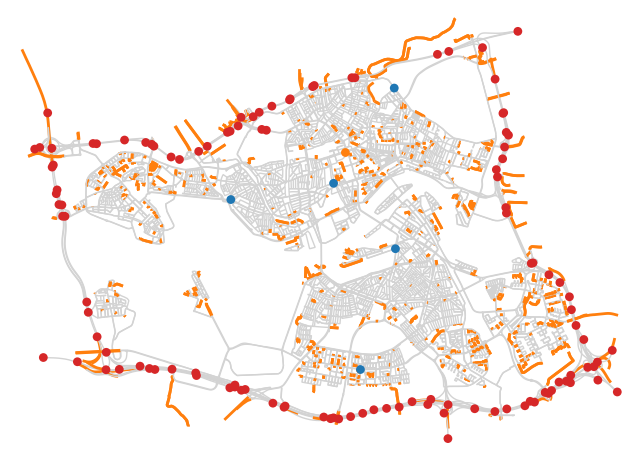

In [29]:
node_size, node_color = node_colors(G_orig, escape_nodes, fugitive_start, police_start)
edge_size, edge_color = edge_colors(G_orig, G)
ox.plot_graph(G_orig, 
                    bgcolor="white", node_color=node_color, node_size=node_size, 
                    edge_linewidth=edge_size, edge_color=edge_color,
                    # show=True, save=True, filepath=f'figs/{city}_pruned_{tolerance}.png'
                    show=False
                    )
plt.savefig(f'./figs/{city}_pruned_deleted_edges.png', dpi=300)

In [183]:
# def edge_colors(G, G_pruned):
#     edge_color = ['lightgray'] * len(G.edges())
#     edge_size = [1] * len(G.edges())
#     # index=-1
#     # for u, v, data in G.edges(data=True):
#     #     index+=1
#     #     if data['osmid'] not in [data_['osmid'] for u_, v_, data_ in G_pruned.edges(data=True)]:
#     #         edge_color[index] = 'black'
#     #         edge_size[index] = 2
#     return edge_size, edge_color
# 
# def node_colors(G, escape_nodes, fugitive_start, police_start):
#     node_size = []
#     node_color = []
#     for u, data in G.nodes(data=True):
#         if u == fugitive_start:
#             node_size.append(40)
#             node_color.append('tab:orange')
#         elif u in police_start:
#             node_size.append(40)
#             node_color.append('tab:blue')
#         elif u in escape_nodes:
#             node_size.append(40)
#             node_color.append('tab:red')
#         elif u not in [data_['osmid_original'] for u_, data_ in G_pruned.nodes(data=True)]:
#             node_size.append(5)
#             node_color.append('black')
#         
#         else:
#             node_size.append(0)
#             node_color.append('lightgray')
#     
#     return node_size, node_color
# 
# node_size, node_color = node_colors(G, escape_nodes, fugitive_start, police_start)
# edge_size, edge_color = edge_colors(G, G_pruned)
# ox.plot_graph(G, 
#                     bgcolor="white", node_color=node_color, node_size=node_size, 
#                     edge_linewidth=edge_size, edge_color=edge_color,
#                     # show=True, save=True, filepath=f'figs/{city}_pruned_{tolerance}.png'
#                     show=False
#                     )
# plt.savefig(f'./figs/{city}_pruned_deleted_nodes.png', dpi=300)

# Permutations

In [184]:
# import ast
# 
# pruned_ids_dict = {}
# for node, data in G_pruned.nodes(data=True):
#     if isinstance(data['osmid_original'], int):
#         pruned_ids_dict[node] = int(data['osmid_original'])
#     elif isinstance(data['osmid_original'], str):
#         pruned_ids_dict[node] = ast.literal_eval(data['osmid_original'])[0]
#     elif isinstance(data['osmid_original'], float):
#         pruned_ids_dict[node] = int(data['osmid_original'])
#     elif isinstance(data['osmid_original'], list):
#         print(node, 'hey')
#         pruned_ids_dict[node] = int(data['osmid_original'][0])
# nx.relabel_nodes(G_pruned, pruned_ids_dict, copy=False)

In [185]:
# def unit_nodes_func_city(start_police, graph, run_length):
#     """
#     Returns a dict of the reachable nodes within the run length for each unit
#     """
#     unit_nodes = {}
#     for u in range(len(start_police)):
#         unit_nodes[u] = list(nx.single_source_dijkstra_path(G=graph,
#                                        source=start_police[u],
#                                        cutoff=run_length,
#                                        weight='travel_time'
#                                        ).keys()) + [start_police[u]]
# 
#     return unit_nodes

In [186]:
# with open(f'../panchamy/simulation/results/results_routes_sp_orig_{city}.pkl', 'rb') as f:
#     route_fugitive = pickle.load(f)
# # t_max = 0
# # for route in route_fugitive:
# #     if max(route.keys()) > t_max:
# #         t_max = max(route.keys())
# route_fugitive = [list(route.values()) for route in route_fugitive]

In [187]:
# print('original graph')
# unit_nodes = unit_nodes_func_city(police_start, G, 1800)
# fugitive_nodes = set([num for sublist in route_fugitive for num in sublist])
# 
# num_options = {}
# num_permutations = 1
# for u in range(len(police_start)):
#     police_nodes = set([y for x in [unit_nodes[u]] for y in x])
#     node_subset = (list(fugitive_nodes.intersection(police_nodes)))
#     num_options[u] = len(node_subset)
#     num_permutations=num_permutations*num_options[u]
#     print(u, num_options[u])
# print(num_permutations)

In [188]:
# if city == 'Winterswijk':
#     police_addresses = [{'lat': 51.96730689392284, 'lon': 6.717868176220198},  # Dingstraat 38
#                         {'lat': 51.93473914644306, 'lon': 6.808688143805569},  # Duitsland Oost
#                         {'lat': 52.03601213823647, 'lon': 6.822783925913308},  # Duitsland Noord
#                         ]
#     fugitive_start = ox.nearest_nodes(G_pruned, 6.7150548, 51.9741482)
# elif city == 'Utrecht':
#     police_addresses = [{'lat': 52.09480988724321, 'lon': 5.112300488054929},  # 'Kroonstraat 25, Utrecht',
#                         {'lat': 52.106435888123734, 'lon': 5.081021768548001},
#                         {'lat': 52.11657425557721, 'lon': 5.106787541127556},
#                         {'lat': 52.077098634761406, 'lon': 5.123281701661107},  # 'Briljantlaan 3, Utrecht',
#                         {'lat': 52.07221414683985, 'lon': 5.0946141119890545}  # 'Marco Pololaan 6, Utrecht'
#                         ]
#     fugitive_start = ox.nearest_nodes(G_pruned, 5.123583852763527, 52.09520282139232)
# elif city == 'Manhattan':
#     police_addresses = [{'lat': 40.75670564515611, 'lon': -73.97082852600276},  # 51st & 3rd
#                         {'lat': 40.74287247577036, 'lon': -73.99856976473754},  # 20th & 7th
#                         {'lat': 40.72638720293323, 'lon': -73.98796587163713},  # 5th & 2nd
#                         {'lat': 40.712326498711, 'lon': -74.00093381696188},  # Madison
#                         {'lat': 40.71627379693516, 'lon': -73.98401898908662},  # Broome & Pitt
#                         ]
#     fugitive_start = ox.nearest_nodes(G_pruned, -73.98959647256116, 40.73585784808693)
# elif city == 'Amsterdam':
#     police_addresses = [{'lat': 52.444181727658865, 'lon': 4.839227926343865},  # noord
#                         {'lat': 52.30236635114219, 'lon': 4.863404367567513},  # amstelveen
#                         {'lat': 52.29749485181312, 'lon': 4.974119183183689},  # ZO
#                         {'lat': 52.36406225532534, 'lon': 4.838630215024896},  # west
#                         {'lat': 52.3574596444559, 'lon': 4.927086601394641},  # watergraafsmeer
#                         ]
#     fugitive_start = ox.nearest_nodes(G_pruned, 4.9196653961917365, 52.38554053106049)
# elif city == 'Rotterdam':
#     police_addresses = [{'lat': 51.94242030923665, 'lon': 4.496820222954058},
#                         {'lat': 51.91263550263607, 'lon': 4.4340630196908535},
#                         {'lat': 51.90196233470228, 'lon': 4.495848688947844},
#                         {'lat': 51.873202510428364, 'lon': 4.482871571074227},
#                         {'lat': 51.91661711602705, 'lon': 4.4728571368682175},
#                         ]
#     fugitive_start = ox.nearest_nodes(G_pruned, 4.477156214899593, 51.924154371892584)
#     
# start_police = []
# for pol in police_addresses:
#     node = ox.nearest_nodes(G, pol['lon'], pol['lat'])
#     start_police.append(node)

In [189]:
# import ast
# print('pruned graph')
# unit_nodes = {}
# for u in range(len(start_police)):
#     unit_nodes_u = set(list(nx.single_source_dijkstra_path(G=G_pruned,
#                                    source=start_police[u],
#                                    cutoff=1800,
#                                    weight='travel_time'
#                                    ).keys()) + [start_police[u]])
#     # unit_nodes_u = set()
#     # for node, data in G_pruned.nodes(data=True):
#     #     if node in unit_nodes_u_:
#     #         if isinstance(data['osmid_original'], int):
#     #             unit_nodes_u.add(data['osmid_original'])
#     #         elif isinstance(data['osmid_original'], str):
#     #             my_list = ast.literal_eval(data['osmid_original'])[0]
#     #             for i in my_list:
#     #                 unit_nodes_u.add(i) 
#     #         elif isinstance(data['osmid_original'], float):
#     #             unit_nodes_u.add(int(data['osmid_original']))
#     #         elif isinstance(data['osmid_original'], list):
#     #             print(node, 'hey')
#     #             for i in range(len(data['osmid_original'])):
#     #                 unit_nodes_u.add(int(data['osmid_original'][0])) 
#     unit_nodes[u] = unit_nodes_u
# 
# fugitive_nodes = set([num for sublist in route_fugitive for num in sublist])
# 
# num_options = {}
# num_permutations_pruned = 1
# for u in range(len(police_start)):
#     police_nodes = set([y for x in [unit_nodes[u]] for y in x])
#     node_subset = (list(fugitive_nodes.intersection(police_nodes)))
#     num_options[u] = len(node_subset)
#     num_permutations_pruned*=num_options[u]
#     print(u, num_permutations_pruned)

In [190]:
# print(len(fugitive_nodes))
# print(len(police_nodes))
# print(len(node_subset))
# print(num_permutations_pruned)

In [191]:
# print(city)
# print('num nodes orig graph: ', len(G.nodes()))   
# print('num nodes pruned graph: ', len(G_pruned.nodes()))   
# print('pct pruned: ', len(G_pruned.nodes())/len(G.nodes()))   
# print(num_permutations, num_permutations_pruned)
# print('pct reduction permutations: ', num_permutations_pruned/num_permutations)

In [192]:
# ox.save_graphml(G_pruned, f"results/pruned_network_{city}.graph.graphml")